# Using the Infidelity errors (either from Calibration or a Noise Model) to Model a Circuit

Randomly adding bitflips, and adding measurement errors at the end as well (using data from `/data` and scripts from `/src`)

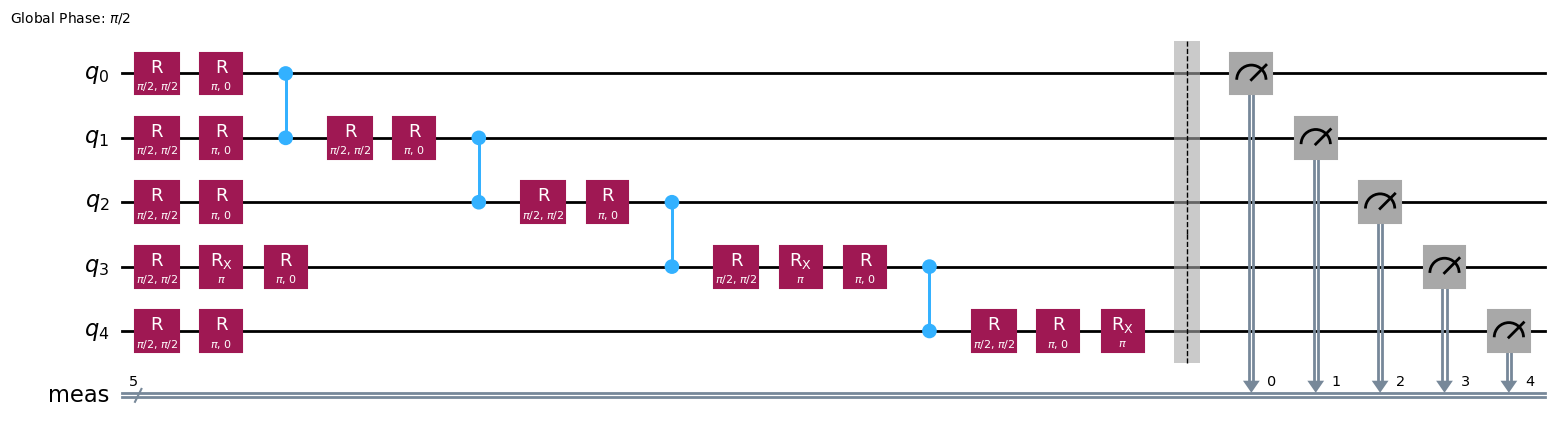

In [1]:
from BitFlipper import add_BitFlips
from qiskit import QuantumCircuit, transpile

def get_test_circuit(n_qubits=5):
    qc = QuantumCircuit(n_qubits)
    
    # 1. Create Superposition on the first qubit
    # (Tests single-qubit 'r' gate noise)
    qc.h(0)
    
    # 2. Entangle neighbors linearly (Chain)
    # (Tests two-qubit 'cx' crosstalk/ZZ noise)
    for i in range(n_qubits - 1):
        qc.cx(i, i+1)
        
    # 3. Measurement (Optional, depending on if your simulator needs it)
    qc.measure_all()
    
    return qc

# Generate and print
seed = 42
qc = get_test_circuit(5)

native_gates = ['r', 'rz', 'cz'] 

# 3. Transpile
# optimization_level=3 tries hardest to reduce gate count
circuit = transpile(qc, basis_gates=native_gates, optimization_level=3)
noisy_circuit = add_BitFlips(circuit)

circuit.draw("mpl")
noisy_circuit.draw("mpl")

## Simulating a circuit applying a Hadamard to each qubit

Since we only have Gate errors, each qubit should be in a perfect 50/50 superposition of |0> and |1>

Use `measure_error = True` to see effects of Measurement Error

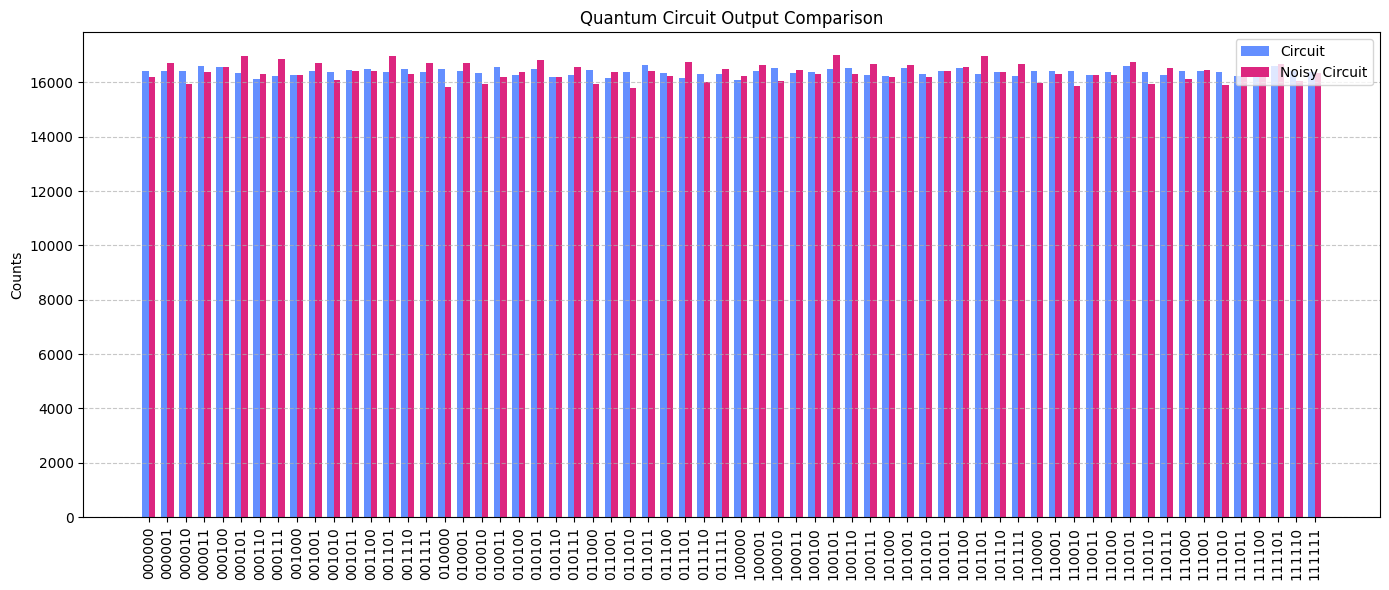


The average value of each qubit, from 0 to n-1 is: [0.49962046641594304, 0.4968519947561211, 0.5000779382951601, 0.5041289849046177, 0.4969198556939286, 0.5065547967982782]


In [35]:
from Qubit_Simulator import Hadamard_Simulator

results = Hadamard_Simulator(num_qubits = 6, shots = 2**20, measure_error = True)#, datafile = "qubit_data")

print("\nThe average value of each qubit, from 0 to n-1 is: " + str(results))

## Code to Find Bitstring Counts

This logic is to be found in the `src/Qubit_Simulator.py` script

In [36]:
from qiskit import QuantumCircuit, transpile
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator
import numpy as np
from BitFlipper import add_BitFlips
import random

num_qubits = 5
native_gates = ['r', 'rz', 'cz']
shots = 1024
simulator = AerSimulator()
circ_seed = 312
sim_seed = 254

# Create circuit (Here 1 Hadamard each)

qc = QuantumCircuit(num_qubits)
for i in range(num_qubits):
    qc.h(i)

qc.measure_all()

# Transpile to native gates
circuit = transpile(qc, basis_gates=native_gates, optimization_level=3)
noisy_circuit = add_BitFlips(circuit, seed = circ_seed)

# Run the circuit 
random.seed(sim_seed)
result = simulator.run(circuit, shots=shots, seed = sim_seed).result()
noisy_result = simulator.run(noisy_circuit, shots=shots, seed = sim_seed).result()

# 3. Get counts
counts = result.get_counts()
noisy_counts = noisy_result.get_counts()

bitstring_list = sorted(list(set(counts.keys())))
bitstring_counts = [counts.get(key, 0) for key in sorted(list(set(counts.keys())))]

print(counts)
print("\n")
print("Bitstrings: " + str(bitstring_list))
print("\n")
print("Bitstring Counts: " + str(bitstring_counts))

{'11100': 32, '00010': 27, '11111': 36, '01000': 28, '01001': 34, '01011': 30, '11000': 32, '10010': 26, '10011': 35, '01110': 35, '00000': 36, '10110': 33, '11101': 34, '00110': 28, '01010': 25, '01101': 27, '10111': 29, '11011': 36, '11001': 25, '10000': 38, '00100': 33, '01100': 33, '10101': 34, '00101': 27, '01111': 30, '10001': 36, '11110': 34, '10100': 36, '00111': 46, '11010': 37, '00001': 27, '00011': 25}


Bitstrings: ['00000', '00001', '00010', '00011', '00100', '00101', '00110', '00111', '01000', '01001', '01010', '01011', '01100', '01101', '01110', '01111', '10000', '10001', '10010', '10011', '10100', '10101', '10110', '10111', '11000', '11001', '11010', '11011', '11100', '11101', '11110', '11111']


Bitstring Counts: [36, 27, 27, 25, 33, 27, 28, 46, 28, 34, 25, 30, 33, 27, 35, 30, 38, 36, 26, 35, 36, 34, 33, 29, 32, 25, 37, 36, 32, 34, 34, 36]
